# MachineMax Technical Test - Model Building

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from Codebase.models import TimeSeriesModelEvaluator
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Loading Data

In [2]:
df = pd.read_csv('./data/time-series1.csv')

## Preprocessing Data

In [3]:
# Convert the timestamp to a numerical value
df['timestamp_asint'] = pd.to_datetime(df['timestamp']).astype('int64')

df.head()

,rms,state,timestamp,timestamp_asint
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000


In [4]:
# Encode the categorical state variable using one-hot encoding
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(df[['state']])
df[['States.ACTIVE', 'States.IDLE', 'States.OFF']] = y_encoded.toarray().astype(int)
df['state_encoded'] = np.argmax(y_encoded, axis=1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['timestamp_scaled', 'rms_scaled']] = scaler.fit_transform(df[['timestamp_asint', 'rms']])

In [6]:
df.columns = df.columns.map(str)
df.head()

,rms,state,timestamp,timestamp_asint,States.ACTIVE,States.IDLE,States.OFF,state_encoded,timestamp_scaled,rms_scaled
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000,0,0,1,2,0.000000,0.000263
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000,0,0,1,2,0.001346,0.001721
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000,0,0,1,2,0.002692,0.001304
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000,0,0,1,2,0.004038,0.001377
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000,0,0,1,2,0.005384,0.001670


<Axes: xlabel='timestamp_scaled'>

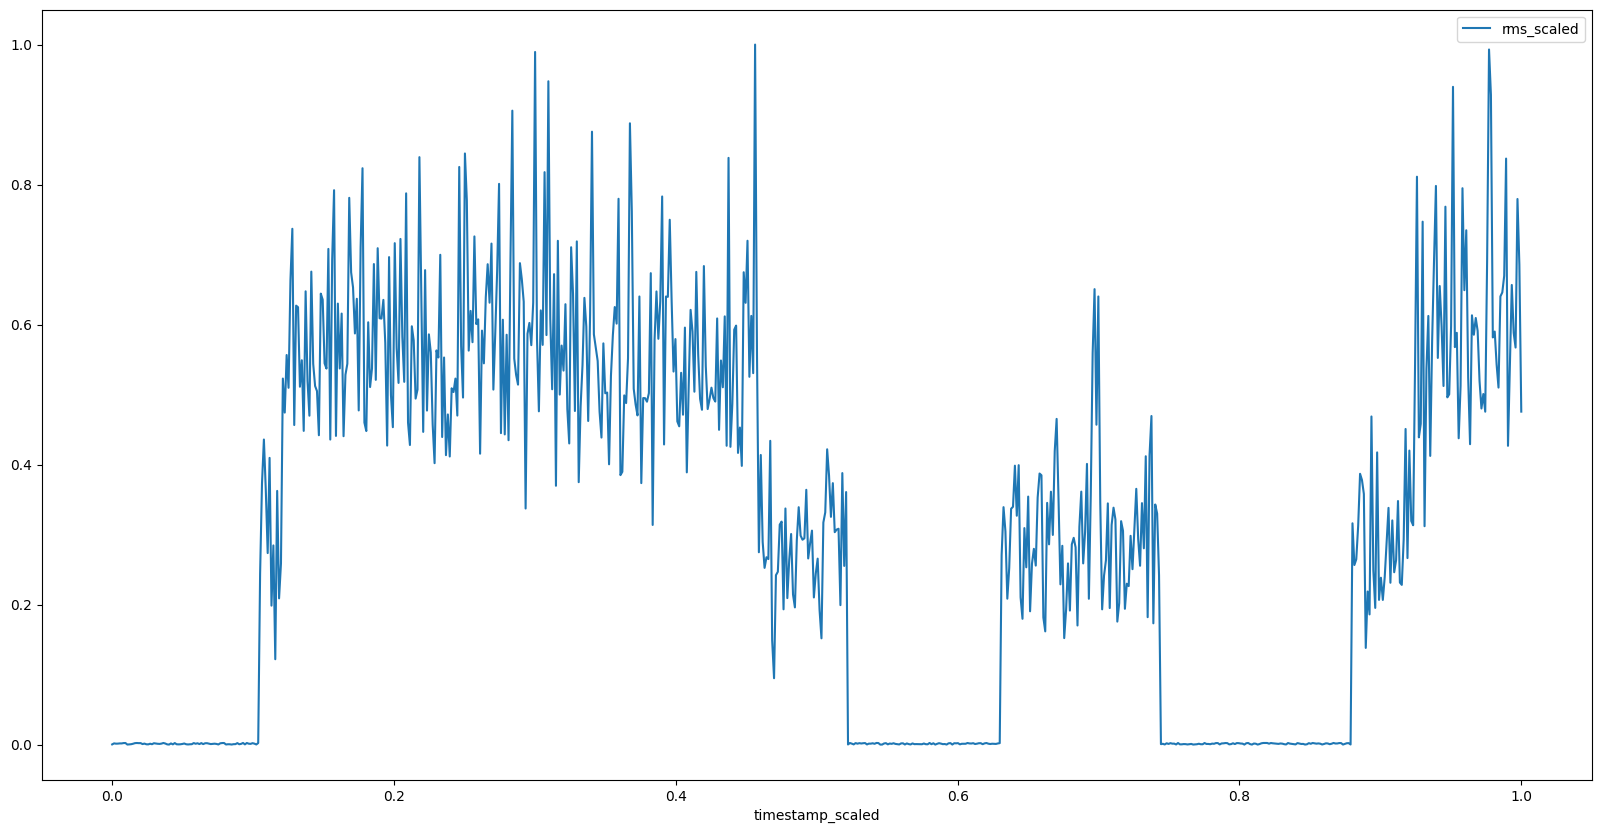

In [7]:
df.plot(x='timestamp_scaled', y='rms_scaled', figsize=(20, 10))

## Model Building

Data will be split using TimeSeriesSplit, which performs cross-validation on the model as follows:

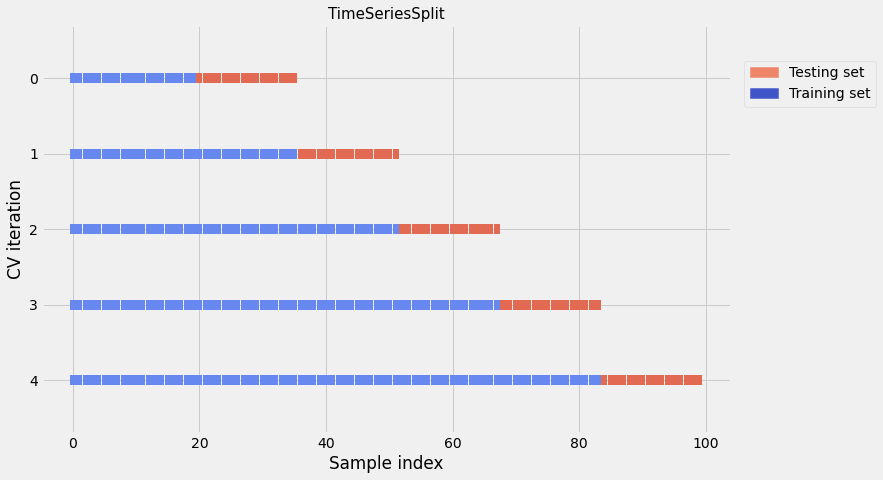

### Logistic Regression

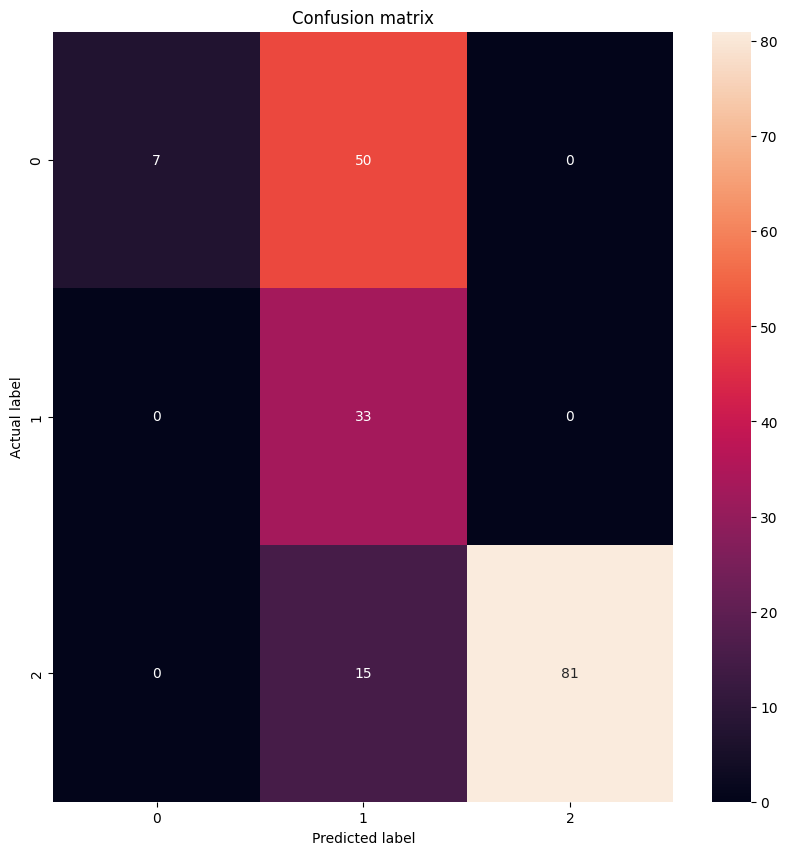

In [8]:
# Train a logistic regression model
model = LogisticRegression()

evaluator = TimeSeriesModelEvaluator(model)

LR_metrics = evaluator.evaluate(
    X=df[['timestamp_scaled', 'rms_scaled']].values,
    y=df['state_encoded'].values
)

In [9]:
# print the metrics
for key, value in LR_metrics.items():
    print(f"{key}: \n{value}\n")

accuracy: 
0.6505376344086021

precision: 
0.7789115646258503

recall: 
0.6555190058479532

f1_score: 
0.5459403437270884

confusion_matrix: 
[[ 7 50  0]
 [ 0 33  0]
 [ 0 15 81]]

classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.12      0.22        57
           1       0.34      1.00      0.50        33
           2       1.00      0.84      0.92        96

    accuracy                           0.65       186
   macro avg       0.78      0.66      0.55       186
weighted avg       0.88      0.65      0.63       186




### XGBoost

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


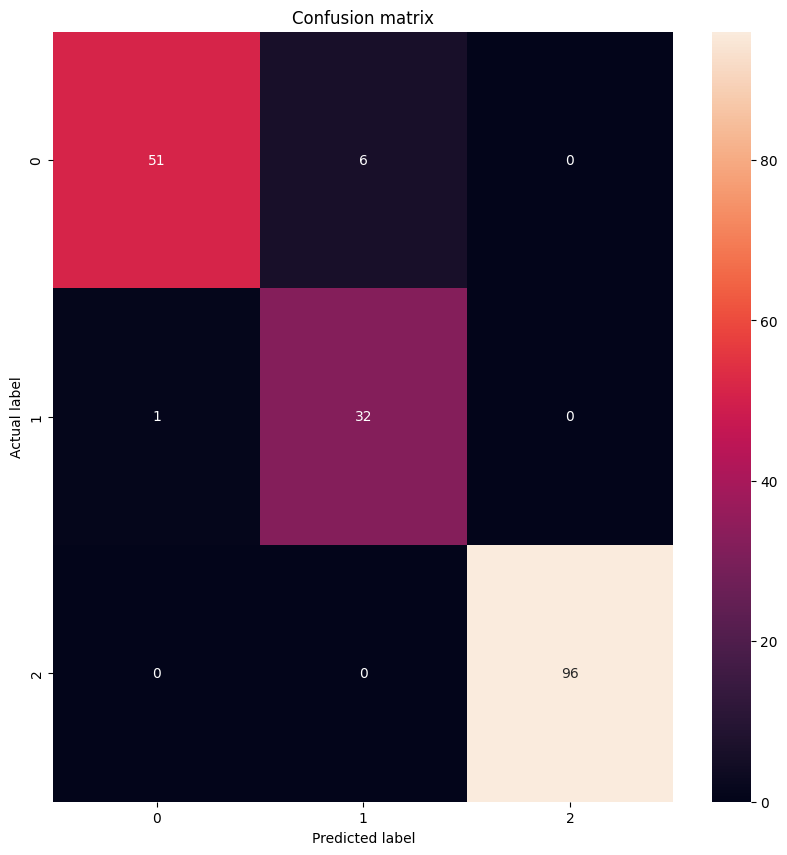

In [12]:
# Instantiate XGBoost classifier
xgb_model = XGBClassifier()

# Hyperparameters for XGBoost
hyperparams = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # This parameter controls the step size shrinkage, which is used to prevent overfitting.
    'max_depth': [3, 4, 5, 6], # This parameter controls the maximum depth of each tree.
    'n_estimators': [50, 100, 200] # This parameter controls the number of estimators or trees in the model.
}

# Instantiate the evaluator with the XGBoost classifier
evaluator = TimeSeriesModelEvaluator(xgb_model, hyperparams)

# Use your dataframe's feature and target columns as X and y
X = df[['timestamp_scaled', 'rms_scaled']].values
y = df['state_encoded'].values

# Evaluate the model
xg_metrics = evaluator.evaluate(X, y, n_splits=5)

In [11]:
# print the metrics
for key, value in xg_metrics.items():
    print(f"{key}: \n{value}\n")

NameError: name 'xg_metrics' is not defined